In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a simple Feedforward Neural Network
class NaiveNN(nn.Module):
    def __init__(self):
        super(NaiveNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Optimized model using JIT compilation for operator fusion
class OptimizedNN(nn.Module):
    def __init__(self):
        super(OptimizedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))  # Fused ReLU operation
        x = self.fc2(x)
        return x


# Training function
def train_model(model, batch_size, epochs=1):
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("training device is ", device)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return model

# Throughput Comparison
def benchmark(model, batch_size, num_batches=10):
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("benchmarking device is ", device)
    model.to(device)
    model.eval()

    total_time = 0
    with torch.no_grad():
        for i, (images, _) in enumerate(testloader):
            if i >= num_batches:
                break
            images = images.to(device)

            if torch.cuda.is_available():
                torch.cuda.synchronize()
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
                start_time.record()
                _ = model(images)
                end_time.record()
                torch.cuda.synchronize()
                total_time += start_time.elapsed_time(end_time)
            else:
                start_time = time.time()
                _ = model(images)
                end_time = time.time()
                total_time += (end_time - start_time) * 1000  # Convert seconds to milliseconds

    return total_time / num_batches



In [5]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
tile_sizes = [32, 64, 128, 256, 512, 1024]
num_trials = 32
results = {}

# Train and benchmark models with different tile sizes
for tile_size in tile_sizes:
    print(f"\nBatch Size: {tile_size}")
    naive_model = train_model(NaiveNN(), batch_size=tile_size, epochs=1)
    optimized_model = train_model(OptimizedNN(), batch_size=tile_size, epochs=1)
    optimized_model = torch.jit.script(optimized_model)  # Apply JIT for further optimization

    naive_times = []
    optimized_times = []

    for _ in range(num_trials):
        naive_times.append(benchmark(naive_model, batch_size=tile_size))
        optimized_times.append(benchmark(optimized_model, batch_size=tile_size))

    naive_mean, naive_std = np.mean(naive_times), np.std(naive_times)
    optimized_mean, optimized_std = np.mean(optimized_times), np.std(optimized_times)

    results[tile_size] = {
        "naive_times": naive_times,
        "naive_mean": naive_mean,
        "naive_std": naive_std,
        "optimized_times": optimized_times,
        "optimized_mean": optimized_mean,
        "optimized_std": optimized_std,
    }

    print(f"Naive Model Avg Inference Time: {naive_mean:.4f} ± {naive_std:.4f} ms per batch")
    print(f"Optimized Model Avg Inference Time: {optimized_mean:.4f} ± {optimized_std:.4f} ms per batch")
    print(f"Speedup: {naive_mean / optimized_mean:.2f}x")


Batch Size: 32
training device is  cuda
training device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchmarking device is  cuda
benchm

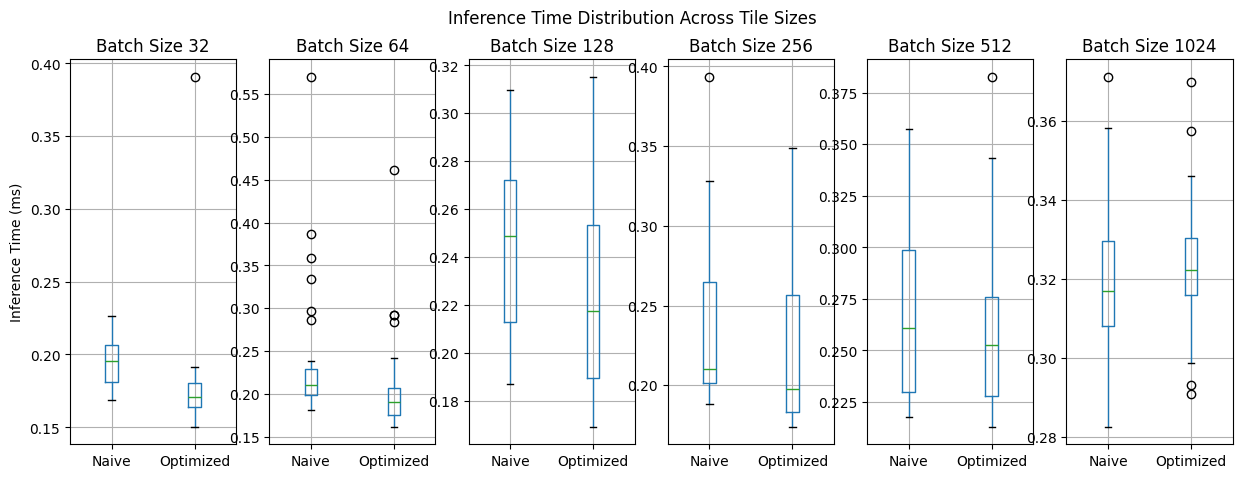

In [7]:
fig, axes = plt.subplots(1, len(tile_sizes), figsize=(15, 5))
for idx, tile_size in enumerate(tile_sizes):
    df = pd.DataFrame({
        "Naive": results[tile_size]["naive_times"],
        "Optimized": results[tile_size]["optimized_times"]
    })

    df.boxplot(ax=axes[idx])
    axes[idx].set_title(f'Batch Size {tile_size}')

axes[0].set_ylabel("Inference Time (ms)")
plt.suptitle("Inference Time Distribution Across Tile Sizes")
plt.show()


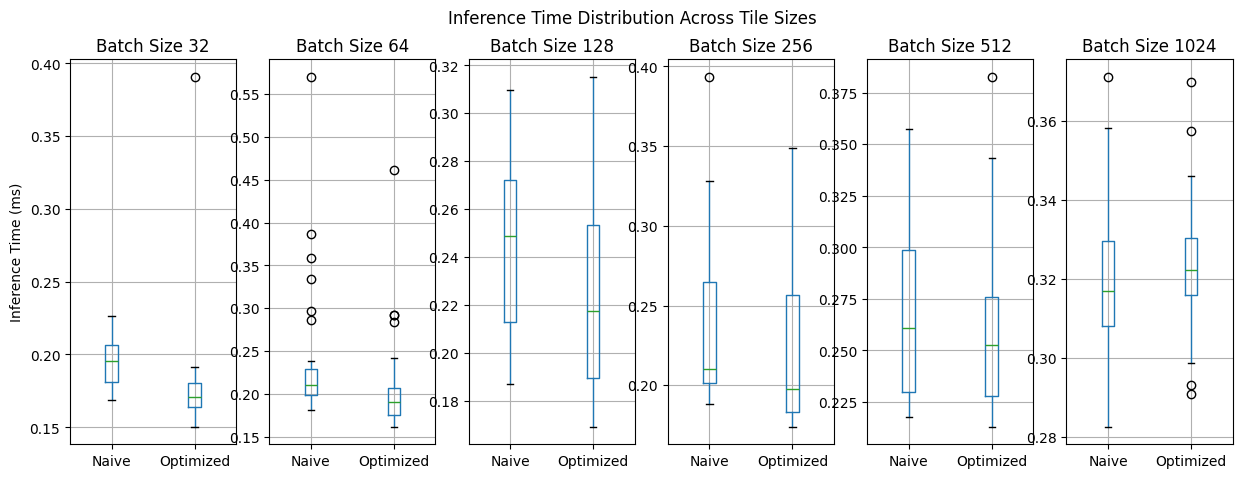

In [8]:
fig, axes = plt.subplots(1, len(tile_sizes), figsize=(15, 5))
for idx, tile_size in enumerate(tile_sizes):
    df = pd.DataFrame({
        "Naive": results[tile_size]["naive_times"],
        "Optimized": results[tile_size]["optimized_times"]
    })

    df.boxplot(ax=axes[idx])
    axes[idx].set_title(f'Batch Size {tile_size}')

axes[0].set_ylabel("Inference Time (ms)")
plt.suptitle("Inference Time Distribution Across Tile Sizes")
plt.show()
